In [1]:
# Setup
from notebook_utils import resolve_paths_from_parent_directory

# auto reload notebook deps
%reload_ext autoreload
%autoreload
resolve_paths_from_parent_directory()

In [2]:
import time
import torch
import torch.optim as optim
from utils import (
    split_img, 
    ToPILImage, 
    ToTensor
)
from tqdm import tqdm
from train import train
from model import SupUCA
from dataset import MNISTHalves
from torchvision import datasets
from torch.utils.data import DataLoader
from match import (
    compute_sims,
    get_matches,
    eval_matches
)
from figure import make_figure

In [3]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load training data
MNIST_train = datasets.MNIST(root='../data/', train=True, download=True)
MNIST_train_tops = []
MNIST_train_bottoms = []

# split training images in half
for i in tqdm(range(MNIST_train.data.shape[0])):
    img = ToPILImage(MNIST_train.data[i])
    x, y = split_img(img)
    MNIST_train_tops.append(ToTensor(x))
    MNIST_train_bottoms.append(ToTensor(y))
MNIST_train_tops = torch.stack(MNIST_train_tops)
MNIST_train_bottoms = torch.stack(MNIST_train_bottoms)
MNIST_train_labels = MNIST_train.targets

# center the training data by removing the mean
MNIST_train_tops_mean = MNIST_train_tops.mean()
MNIST_train_bottoms_mean = MNIST_train_bottoms.mean()
MNIST_train_tops = MNIST_train_tops - MNIST_train_tops_mean
MNIST_train_bottoms = MNIST_train_bottoms - MNIST_train_bottoms_mean

# load test data
MNIST_test = datasets.MNIST(root='../data/', train=False, download=True)
MNIST_test_tops = []
MNIST_test_bottoms = []

# split test images in half
for i in tqdm(range(MNIST_test.data.shape[0])):
    img = ToPILImage(MNIST_test.data[i])
    x, y = split_img(img)
    MNIST_test_tops.append(ToTensor(x))
    MNIST_test_bottoms.append(ToTensor(y))
MNIST_test_tops = torch.stack(MNIST_test_tops)
MNIST_test_bottoms = torch.stack(MNIST_test_bottoms)
MNIST_test_labels = MNIST_test.targets

# center the test data by removing the (training) mean
MNIST_test_tops = MNIST_test_tops - MNIST_train_tops_mean
MNIST_test_bottoms = MNIST_test_bottoms - MNIST_train_bottoms_mean

# build datasets / data loaders
batch_size = 32
MNISTHalves_train = MNISTHalves(MNIST_train_tops, MNIST_train_bottoms, MNIST_train_labels)
MNISTHalves_test = MNISTHalves(MNIST_test_tops, MNIST_test_bottoms, MNIST_test_labels)
MNISTHalves_train_loader = DataLoader(MNISTHalves_train, batch_size=batch_size, shuffle=True)
MNISTHalves_test_loader = DataLoader(MNISTHalves_test, batch_size=batch_size, shuffle=False)

100%|██████████| 10000/10000 [00:04<00:00, 2241.14it/s]


In [4]:
# build model
model = SupUCA()
model.to(device)

# set optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5, amsgrad=True)

# set scheduler
step_size = 15
gamma = 0.5
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [5]:
# # train model
# model = train(model, optimizer, scheduler, MNISTHalves_train_loader, MNISTHalves_test_loader, device, epochs=26)

# # save model
# torch.save(model.state_dict(), '../saved_models/SupUCA.pickle')

# load model
model = SupUCA()
model.load_state_dict(torch.load('../saved_models/SupUCA.pickle'))
model.eval()

SupUCA(
  (W_x): Linear(in_features=392, out_features=10, bias=False)
  (W_y): Linear(in_features=392, out_features=10, bias=False)
  (V_x): Linear(in_features=10, out_features=392, bias=False)
  (V_y): Linear(in_features=10, out_features=392, bias=False)
)

In [6]:
# inference
# full dataset or first n datapoints?
# execution time full: ~1-2m
# execution time first 1000: < ~1s
full = False
if full:
    dataset = MNISTHalves_test
else:
    head = 1000
    dataset = torch.utils.data.Subset(MNISTHalves_test, range(head))

# compute sims
print('compute sims...', end=' ')
beg = time.time()
sims = compute_sims(model, dataset, 'euclidean', device)
end = time.time()
print(f'{end - beg:.1f}s')

# solve min weight matching
print('solve min weight matching...', end=' ')
beg = time.time()
row_ind, col_ind = get_matches(sims)
end = time.time()
print(f'{end - beg:.1f}s')

compute sims... 1.4s
solve min weight matching... 0.3s


In [7]:
# exact matches
eval_matches(dataset, row_ind, col_ind, eval_type='exact')

6.4%


In [8]:
# correct matches
eval_matches(dataset, row_ind, col_ind, eval_type='correct')

50.7%


In [9]:
# correct matches by label
eval_matches(dataset, row_ind, col_ind, eval_type='label')

0: 69.4%
1: 82.5%
2: 53.4%
3: 27.1%
4: 49.1%
5: 29.9%
6: 60.9%
7: 56.6%
8: 29.2%
9: 40.4%


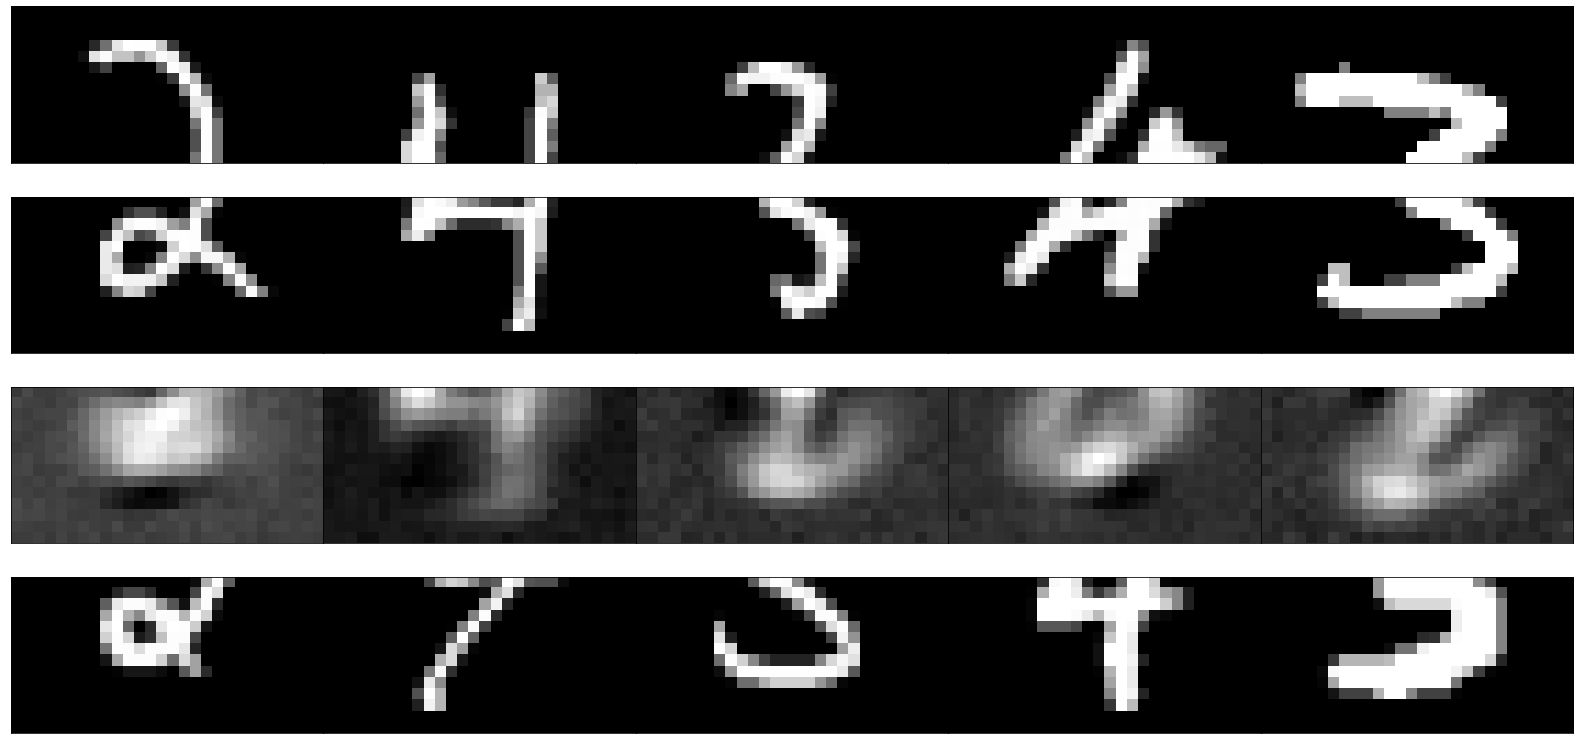

In [10]:
# 1st row is ground truth top
# 2nd row is ground truth bottom
# 3rd row is estimated bottom
# 4th row is retrieved bottom
make_figure(model, dataset, row_ind, col_ind, sample='random')

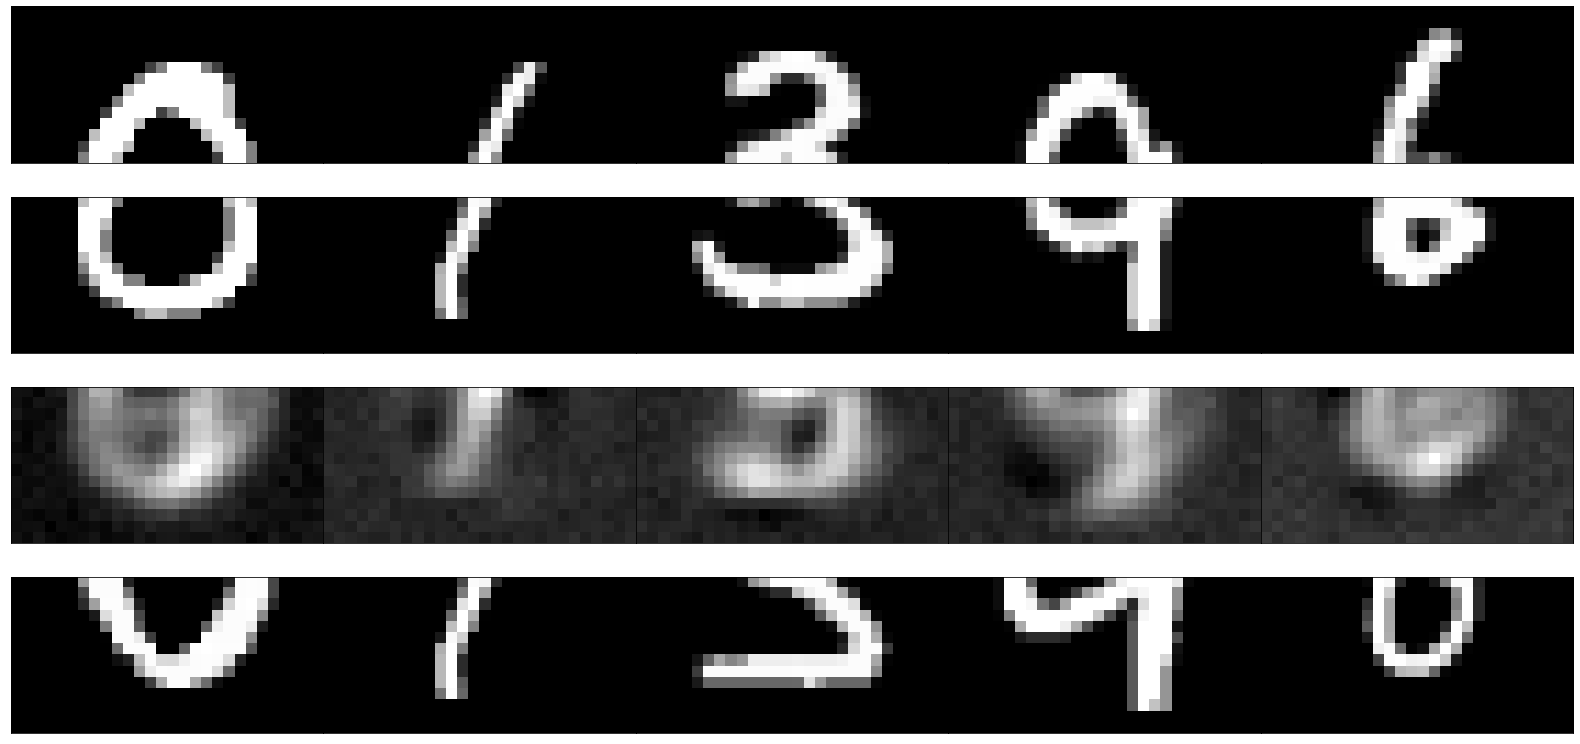

In [11]:
# 1st row is ground truth top
# 2nd row is ground truth bottom
# 3rd row is estimated bottom
# 4th row is retrieved bottom
make_figure(model, dataset, row_ind, col_ind, sample='correct')

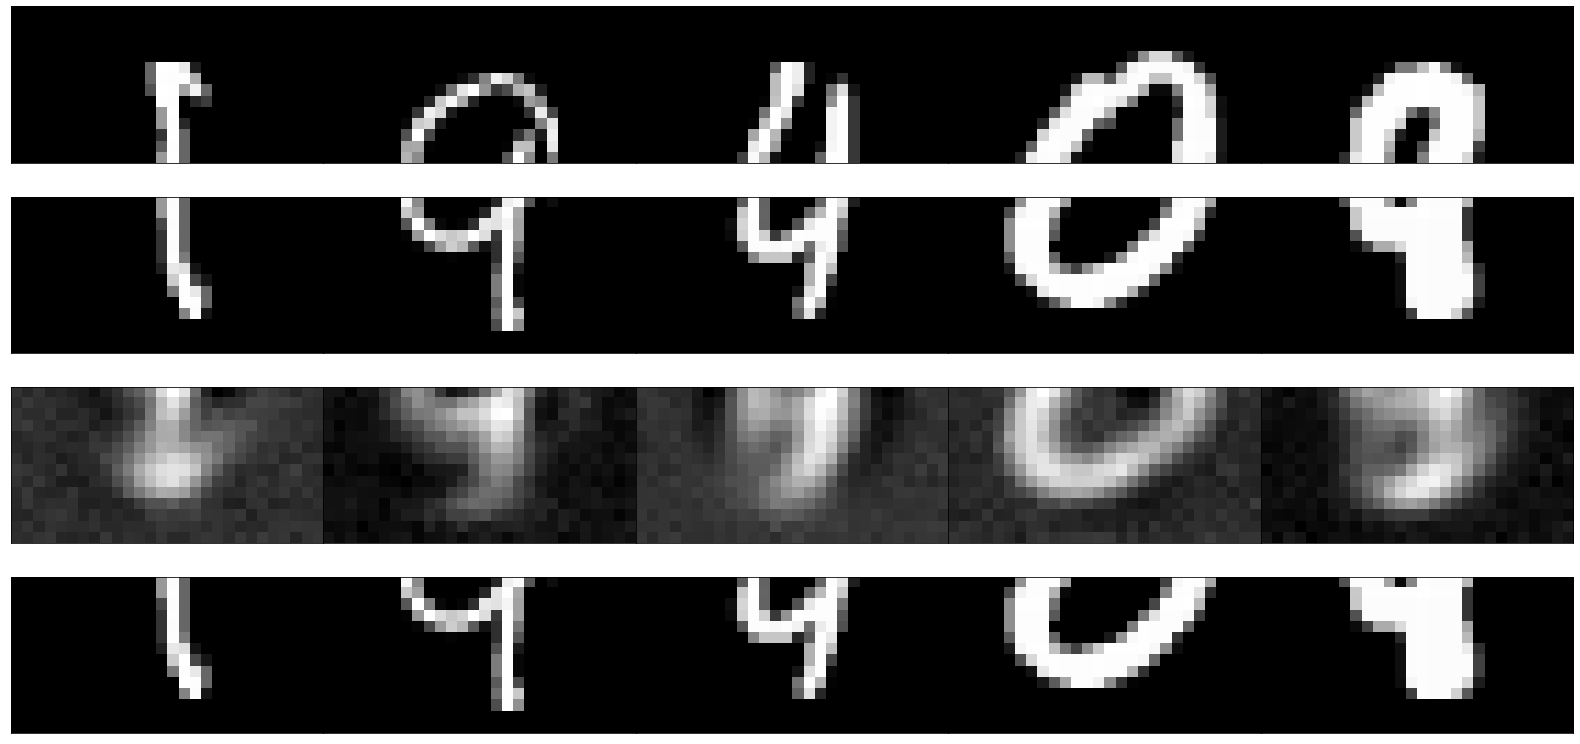

In [12]:
# 1st row is ground truth top
# 2nd row is ground truth bottom
# 3rd row is estimated bottom
# 4th row is retrieved bottom
make_figure(model, dataset, row_ind, col_ind, sample='exact')